In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import torchvision 
import torch
import os
import random 
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmarks=False
os.environ['PYTHONHASHSEED'] = str(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torchvision.transforms as transforms
TRAIN_ON_GPU = torch.cuda.is_available()


In [ ]:
from __future__ import print_function

import os
import numpy as np
from scipy import stats
import pandas as pd

## reading the dataset properly from here! 
def readData(filePath):
    # attributes of the dataset
    columnNames = ['user_id','activity','timestamp','x-axis','y-axis','z-axis']
    data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
    print(data)
    return data
  
# defining a window function for segmentation purposes
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)

# segmenting the time series
def segment_signal(data, window_size = 90):
    segments = np.empty((0,window_size,3))
    labels= np.empty((0)) 
    for (start, end) in windows(data['timestamp'],window_size):
        x = data['x-axis'][start:end]
        y = data['y-axis'][start:end]
        z = data['z-axis'][start:end]
        if(len(data['timestamp'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data['activity'][start:end])[0][0])
    return segments, labels

## ending the dataset preprocessing here!

lam_recon = 0.392
dataset = readData('actitracker_modified2.txt')
print("Read dataset")
# segmenting the signal in overlapping windows of 90 samples with 50% overlap
segments, labels = segment_signal(dataset)
labelname = labels
print(labelname) 
print("Read segment and labels")

#categorically defining the classes of the activities
labels_hot = np.asarray(pd.get_dummies(labels),dtype = np.int8)
labels = np.nonzero(labels_hot)[1]

print(labels)
# defining parameters for the input and network layers
# we are treating each segment or chunk as a 2D image (90 X 3)
numOfRows = segments.shape[1]
numOfColumns = segments.shape[2]
numChannels = 1
print("Going to split into training and validation")

# split ratio for test and validation
trainSplitRatio = 0.8
batch_size = 6
numClasses = 6
#numClasses = labels_hot.shape[1]
# dropout ratio for dropout layer
dropOutRatio = 0.2
# reshaping the data for network input
reshapedSegments = segments.reshape(segments.shape[0], 1, numOfRows, numOfColumns)
# splitting in training and testing data
trainSplit = np.random.rand(len(reshapedSegments)) < trainSplitRatio

trainX = reshapedSegments[trainSplit]
testX = reshapedSegments[~trainSplit]

xtrain = np.nan_to_num(trainX)
xtest = np.nan_to_num(testX)
ytrain = labels[trainSplit]
ytest = labels[~trainSplit]

print("x_test: ", xtest.shape)
print("y_test: ", ytest.shape)
print("x_train: ", xtrain.shape)
print("y_train: ", ytrain.shape)


        user_id activity       timestamp     x-axis     y-axis    z-axis
0            33  Jogging  49105962326000  -0.694638  12.680544  0.503953
1            33  Jogging  49106062271000   5.012288  11.264028  0.953424
2            33  Jogging  49106112167000   4.903325  10.882658 -0.081722
3            33  Jogging  49106222305000  -0.612916  18.496431  3.023717
4            33  Jogging  49106332290000  -1.184970  12.108489  7.205164
...         ...      ...             ...        ...        ...       ...
680291        4  Walking   2875822337000  -0.840000   5.480000  2.220000
680292        4  Walking   2875872325000   4.670000  10.570000  8.080000
680293        4  Walking   2875922374000   4.180000   9.960000  6.510000
680294        4  Walking   2875972362000   6.050000  18.730000  9.510000
680295        4  Walking   2876022319000 -15.980000  -1.880000 -8.160000

[680296 rows x 6 columns]
Read dataset
['Jogging' 'Jogging' 'Jogging' ... 'Walking' 'Walking' 'Walking']
Read segment and l

In [ ]:
x_train = xtrain[:12100]
y_train = ytrain[:12100]
x_test = xtest[:2900]
y_test = ytest[:2900]

In [ ]:
for i in range(0, len(labelname)):
  print(labelname[i])
  print(labels[i])

Streaming output truncated to the last 5000 lines.
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking
5
Walking

0 - downstairs 
1 - jogging 
2 - sitting 
3 - standing 
4 - upstairs 
5 - walking

In [ ]:
x_train = torch.from_numpy(xtrain).float()
y_train = torch.from_numpy(ytrain)
x_test = torch.from_numpy(xtest).float()
y_test = torch.from_numpy(ytest)

train_data = torch.utils.data.TensorDataset(x_train, y_train)
test_data = torch.utils.data.TensorDataset(x_test, y_test)

In [ ]:
torch.save(train_data, 'train_data.pt')
torch.save(test_data, 'test_data.pt')

In [ ]:
train_data = torch.load('train_data.pt')
test_data = torch.load('test_data.pt')

In [ ]:
batch_size = 2
num_workers = 2 
train_loader = torchvision.torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers)
test_loader  = torchvision.torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

def softmax(input_tensor, dim=1):
    # transpose input
    transposed_input = input_tensor.transpose(dim, len(input_tensor.size()) - 1)
    # calculate softmax
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    # un-transpose result
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input_tensor.size()) - 1)

#Squash function 
def squash(u):
  norm = (u ** 2).sum(-1, keepdim=True)
  denom = ((1. + norm) * torch.sqrt(norm))
  if torch.isinf(denom).sum().item()>0:
    squash_output = u / torch.sqrt(norm)
  else:
    squash_output = norm * u / ((1. + norm) * torch.sqrt(norm))
  return squash_output

**Encoder network bold text**

In [ ]:
#The encoder layer before Primary Capsule 
class ConvLayer(nn.Module):
  def __init__(self, in_channels = 1, out_channels = 256):
    super(ConvLayer, self).__init__()
    self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = (2,1), stride = 1, padding = 0)
    
  def forward(self, x):
    out = F.relu(self.conv(x))
    return out


**Primary Capsules**

In [ ]:
class PrimaryCapsule(nn.Module):
  def __init__(self, num_capsules = 8, in_channels = 256, out_channels = 32):
    super(PrimaryCapsule, self).__init__()
    self.capsules = nn.ModuleList([nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = (2,2), stride = 1, padding = 0) for _ in range(0, num_capsules)])
    
  def forward(self, x):
    u = [capsule(x).view(batch_size, 32 * 88 * 2, 1) for capsule in self.capsules]
    u = torch.cat(u, dim=-1)
    # squashing the stack of vectors
    out_squash = squash(u)
    return out_squash


**Digit Capsules**

In [ ]:
class DigitCapsule(nn.Module):
  def __init__(self, num_capsules = 6, num_routes = 32*88*2, in_channels = 8, out_channels = 16):
    super(DigitCapsule, self).__init__()
    #Weight i-j (connecting the primary capsule and the digit capsules)
    self.W = nn.Parameter(torch.randn(num_capsules, num_routes, in_channels, out_channels))

  def forward(self, u):
    u = u[None, :, : , None, :]
    W = self.W[:, None, :, :, :]
    u_hat = torch.matmul(u, W)
    b_ij = torch.zeros(*u_hat.size())
    if TRAIN_ON_GPU:
      b_ij = b_ij.cuda()
      u_hat = u_hat.cuda()
    '''b_ij.to(device)
    u_hat.to(device)'''
    iterations = 3
    for i in range(0, iterations):
      c_ij = softmax(b_ij, dim=2)
      if TRAIN_ON_GPU:
          c_ij = c_ij.cuda()
      # calculating total capsule inputs
      s_j = (c_ij * u_hat).sum(dim=2, keepdim=True)
      # squashing to get a normalized vector output, v_j
      v_j = squash(s_j)
      # if not on the last iteration, calculate agreement and new b_ij
      if i < iterations - 1:
        # agreement
        a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)
        # new b_ij
        b_ij = b_ij + a_ij

    return v_j 

**Decoder for DigitCapsules**

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_vector=16, num_capsules=6, hidden_dim=512):
        super(Decoder, self).__init__()
        # calculate input_dim
        input_dim = in_vector * num_capsules
        
        #Dense layers for decoder network
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # first hidden layer
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2), # second, twice as deep
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim*2, 90*3), # can be reshaped into 90*3 image
            nn.Sigmoid() # sigmoid activation to get output pixel values in a range from 0-1
            )
        
    def forward(self, x):
        classes = (x ** 2).sum(dim=-1) ** 0.5
        #classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        # Identify the capsule with maximum vector length - indicating the probability of each class
        _, max_length_indices = classes.max(dim=1)
        # We create a sparse matrix for 6 classes
        sparse_matrix = torch.eye(6) 
        if TRAIN_ON_GPU:
            sparse_matrix = sparse_matrix.cuda()
        # compute the classes score from the "correct" capsule
        y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)
        # create reconstructed pixels
        x = x * y[:, :, None]
        # flatten image into a vector shape (batch_size, vector_dim)
        flattened_vector = x.contiguous().view(x.size(0), -1)
        # create reconstructed image vectors
        reconstructions = self.linear_layers(flattened_vector)
        
        # return reconstructions and the class scores, y
        return reconstructions, y


**Connecting all the above layers with each other**

In [ ]:
class CapsNet(nn.Module):
  def __init__(self):
    super(CapsNet, self).__init__()
    self.ConvLayer = ConvLayer()
    self.PrimaryCapsule = PrimaryCapsule()
    self.DigitCapsule = DigitCapsule()
    self.Decoder = Decoder()
  def forward(self, inputs):
    pricaps_out = self.PrimaryCapsule(self.ConvLayer(inputs))
    digicaps_out = self.DigitCapsule(pricaps_out).squeeze().transpose(0,1)
    recon, y = self.Decoder(digicaps_out)
    return digicaps_out, recon, y

In [ ]:
capsnet = CapsNet()
if TRAIN_ON_GPU:
    capsnet.cuda()

In [ ]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(reduction='sum') # cumulative loss

    def forward(self, inputs, digicaps_out, labels, reconstructions):
        batch_size = digicaps_out.size(0)
        ##  calculate the margin loss   ##
        # get magnitude of digit capsule vectors, v_c
        digicaps_vector = torch.sqrt((digicaps_out**2).sum(dim=2, keepdim=True))

        # calculate "correct" and incorrect loss
        correct = F.relu(0.9 - digicaps_vector).view(batch_size, -1)
        incorrect = F.relu(digicaps_vector - 0.1).view(batch_size, -1)
        '''print(correct.shape)
        print(incorrect.shape)
        print(labels)'''
        # sum the losses, with a lambda = 0.5
        margin_loss = labels * correct + 0.5 * (1. - labels) * incorrect
        margin_loss = margin_loss.sum()

        ##  calculate the reconstruction loss   ##
        inputs = inputs.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, inputs)

        # return a sum of margin and reconstruction loss, averaged over one batch size
        return (margin_loss + 0.0005 * reconstruction_loss) / inputs.size(0)


In [ ]:
criterion = CustomLoss()
optimizer = optim.Adam(capsnet.parameters())

In [ ]:
losses = []
train_acc_val = []
train_loss_val = []
iteration = []  

In [ ]:
def train(capsule_net, criterion, optimizer, epochs):

    for epoch in range(1, epochs+1):
        correct_class = list(0 for i in range(6))
        total_class = list(0 for i in range(6))
        train_loss = 0.0
        capsnet.train() # set to train mode
        # get batches of training image data and targets
        for i, (inputs, target) in enumerate(train_loader):
            # reshape and get target class
            target = torch.eye(6).index_select(dim=0, index=target)
            inputs, target = inputs.cuda(), target.cuda()
            # zero out gradients
            optimizer.zero_grad()
            # get model outputs
            digicaps_out, recon, y = capsnet(inputs)
            # calculate loss
            loss = criterion(inputs, digicaps_out, target, recon)
            # perform backpropagation and optimization
            loss.backward()
            optimizer.step()
            _, pred = torch.max(y.data.cpu(), 1)
            _, target_shape = torch.max(target.data.cpu(), 1)
            # compare predictions to true label
            correct = np.squeeze(pred.eq(target_shape.data.view_as(pred)))
            train_loss += loss.item() # accumulated training loss
            for k in range(batch_size):
              label = target_shape.data[k]
              correct_class[label] += correct[k].item()
              total_class[label] += 1
            # print and record training stats
            if i != 0 and i % 500 == 0:
                avg_train_loss = train_loss/500
                losses.append(avg_train_loss)
                print('Epoch: {} \tTraining Loss: {:.8f}'.format(epoch, avg_train_loss))
                train_loss = 0 # reset accumulated training loss
        print("Training accuracy is:", np.sum(correct_class) / float((batch_size*i)))
        train_acc_val.append(np.sum(correct_class) / float((batch_size*i)))
        train_loss_val.append(train_loss / float(i))
        iteration.append(epoch)
        
    return losses


In [ ]:
epochs = 10
losses = train(capsnet, criterion, optimizer, epochs)


Epoch: 1 	Training Loss: 7.39147565
Epoch: 1 	Training Loss: 7.36586278
Epoch: 1 	Training Loss: 7.95724767
Epoch: 1 	Training Loss: 6.95977076
Epoch: 1 	Training Loss: 7.94663804
Epoch: 1 	Training Loss: 7.59853663
Epoch: 1 	Training Loss: 6.03336207
Epoch: 1 	Training Loss: 7.56629073
Epoch: 1 	Training Loss: 7.16783556
Epoch: 1 	Training Loss: 7.60497200
Epoch: 1 	Training Loss: 7.05905496
Epoch: 1 	Training Loss: 8.93404004
Training accuracy is: 0.6849991766836818
Epoch: 2 	Training Loss: 7.19588668
Epoch: 2 	Training Loss: 7.29100679
Epoch: 2 	Training Loss: 7.93392074
Epoch: 2 	Training Loss: 7.03574790
Epoch: 2 	Training Loss: 7.72947113
Epoch: 2 	Training Loss: 7.46792636
Epoch: 2 	Training Loss: 6.01848351
Epoch: 2 	Training Loss: 7.36586992
Epoch: 2 	Training Loss: 7.04143199
Epoch: 2 	Training Loss: 7.51230889
Epoch: 2 	Training Loss: 7.02378761
Epoch: 2 	Training Loss: 8.68311161
Training accuracy is: 0.7760579614687964
Epoch: 3 	Training Loss: 7.07887642
Epoch: 3 	Training

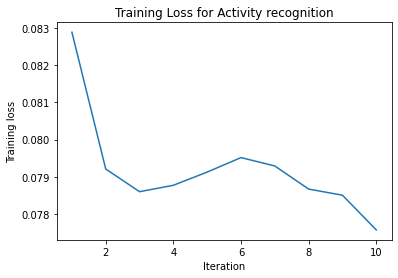

In [ ]:
plt.plot(iteration, train_loss_val)
plt.title("Training Loss for Activity recognition")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.show()


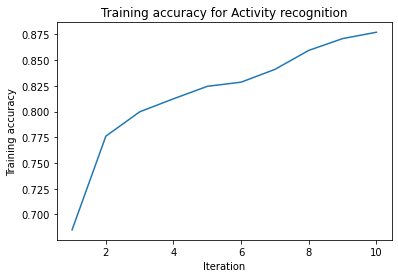

In [ ]:
plt.plot(iteration, train_acc_val)
plt.title("Training accuracy for Activity recognition")
plt.xlabel("Iteration")
plt.ylabel("Training accuracy")
plt.show()

0 - downstairs 
1 - jogging 
2 - sitting 
3 - standing 
4 - upstairs 
5 - walking

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


classes = ('downstairs', 'jogging', 'sitting', 'standing',
           'upstairs', 'walking')

def test(capsule_net, test_loader):
    a = []
    b = []

    correct_class = list(0 for i in range(6))
    total_class = list(0 for i in range(6))
    
    test_loss = 0 # loss tracking
    capsule_net.eval() # eval mode

    for n, (inputs, target) in enumerate(test_loader):
        target = torch.eye(6).index_select(dim=0, index=target)
        batch_size = 2
        inputs, target = inputs.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        digicaps_out, recon, y = capsnet(inputs)
        # calculate the loss
        loss = criterion(inputs, digicaps_out, target, recon)
        # update average test loss 
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(y.data.cpu(), 1)
        _, target_shape = torch.max(target.data.cpu(), 1)

        # compare predictions to true label
        correct = np.squeeze(pred.eq(target_shape.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target_shape.data[i]
            correct_class[label] += correct[i].item()
            total_class[label] += 1

        for i in pred:
            a.append(i)
        for k in target_shape:
            b.append(k)

    a = np.array(a)
    b = np.array(b)
    cm = confusion_matrix(a,b)

    fig = plt.figure()
    ax = plt.subplot()
    sn.set(font_scale=1) # Adjust to fit
    sn.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'12'}  # Adjust to fit
    ax.set_xlabel('Actual labels', fontdict=label_font);
    ax.set_ylabel('Predicted labels', fontdict=label_font);

    title_font = {'size':'12'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
    ax.xaxis.set_ticklabels(['downstairs', 'jogging', 'sitting', 'standing', 'upstairs', 'walking']);
    ax.yaxis.set_ticklabels(['downstairs', 'jogging', 'sitting', 'standing', 'upstairs', 'walking']);
    plt.show()
    fig.savefig('cm_activity.jpg')

    avg_test_loss = test_loss/len(test_loader)
    print('Test Loss of CIFAR-10 dataset: {:.4f}\n'.format(avg_test_loss))
    print('Test accuracy of individual classes are as follows: \n')
    for i in range(6):
        if total_class[i] > 0:
            print('Test Accuracy of class %1s: %2d%% (%2d/%2d)' % (
                str(classes[i]), 100 * correct_class[i] / total_class[i],
                np.sum(correct_class[i]), np.sum(total_class[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (i))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))
    
    # return last batch of capsule vectors, images, reconstructions
    return digicaps_out, inputs, recon


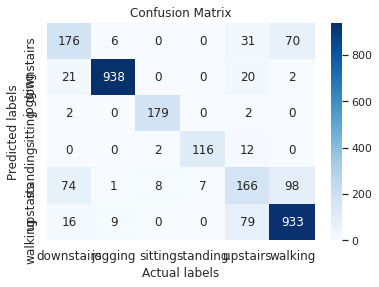

Test Loss of CIFAR-10 dataset: 7.2168

Test accuracy of individual classes are as follows: 

Test Accuracy of class downstairs: 60% (176/289)
Test Accuracy of class jogging: 98% (938/954)
Test Accuracy of class sitting: 94% (179/189)
Test Accuracy of class standing: 94% (116/123)
Test Accuracy of class upstairs: 53% (166/310)
Test Accuracy of class walking: 84% (933/1103)

Test Accuracy (Overall): 84% (2508/2968)


In [ ]:
digicaps_out, inputs, recon = test(capsnet, test_loader)